In [1]:
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
csv = '../driving_log.csv'
data = pd.read_csv(csv)

In [2]:
len(data)

8036

In [3]:
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


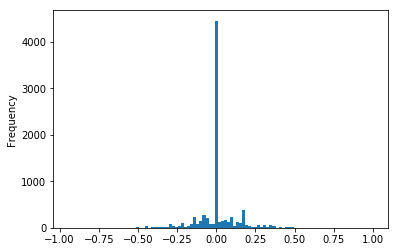

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

data['steering'].plot.hist(bins=100)

## 三个视角

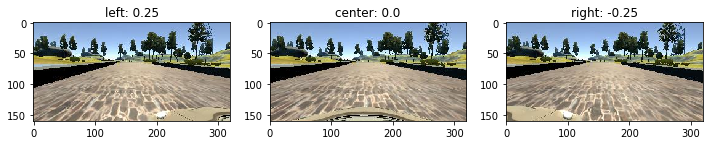

In [5]:
import cv2

STEER = 0.25

left_image = cv2.imread('../' + data['left'][0].strip())
left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
left_steer = data['steering'][0] + STEER

center_image = cv2.imread('../' + data['center'][0].strip())
center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
center_steer = data['steering'][0]

right_image = cv2.imread('../' + data['right'][0].strip())
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
right_steer = data['steering'][0] - STEER

plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
plt.imshow(left_image)
plt.title('left: ' + str(left_steer))

plt.subplot(1, 3, 2)
plt.imshow(center_image)
plt.title('center: ' + str(center_steer))

plt.subplot(1, 3, 3)
plt.imshow(right_image)
plt.title('right: ' + str(right_steer))

## 截取

In [6]:
CROP = range(60, 140)


def crop(image):
    return image[CROP]

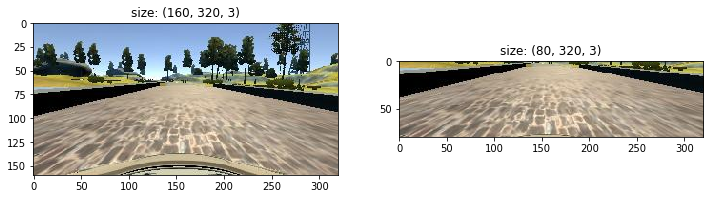

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(center_image)
plt.title('size: ' + str(center_image.shape))

plt.subplot(1, 2, 2)
crop_image = crop(center_image)
plt.imshow(crop_image)
plt.title('size: ' + str(crop_image.shape))

## 放缩

In [8]:
RESIZE = (200, 66)


def resize(image):
    return cv2.resize(image, RESIZE)

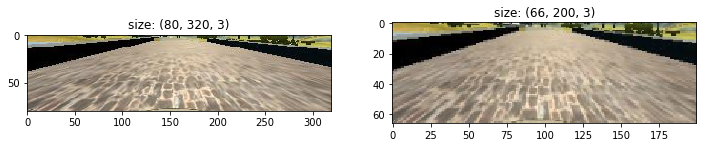

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(crop_image)
plt.title('size: ' + str(crop_image.shape))

plt.subplot(1, 2, 2)
resize_image = resize(crop_image)
plt.imshow(resize_image)
plt.title('size: ' + str(resize_image.shape))

## 对称

In [10]:
def flip(image):
    return cv2.flip(image, 1)

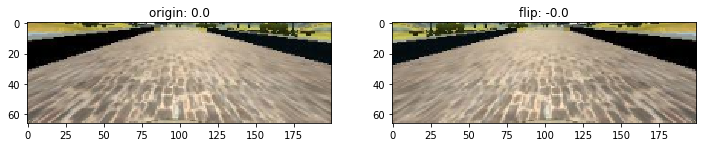

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(resize_image)
plt.title('origin: ' + str(center_steer))

plt.subplot(1, 2, 2)
flip_image = flip(resize_image)
plt.imshow(flip_image)
plt.title('flip: ' + str(center_steer * -1))

## 数据增强

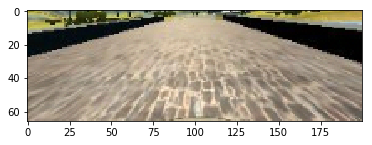

In [12]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)


def sometime(aug): return iaa.Sometimes(0.3, aug)


sequence = iaa.Sequential([
    sometime(iaa.GaussianBlur((0, 1.5))),
    sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))),
    sometime(iaa.AdditiveGaussianNoise(
        loc=0, scale=(0.0, 3.), per_channel=0.5)),
    sometime(iaa.Dropout((0.0, 0.1))),
    sometime(iaa.CoarseDropout((0.10, 0.30),
                               size_percent=(0.02, 0.05), per_channel=0.2)),
    sometime(iaa.Add((-10, 10), per_channel=0.5)),
],
    random_order=True
)

image = sequence.augment_image(flip_image)
plt.imshow(image)

## 数据读取

In [13]:
import numpy as np


def getview(index):
    rnd = np.random.randint(0, 3)
    if rnd == 0:
        image = '../' + data['left'][index].strip()
        steer = data['steering'][index] + STEER
    elif rnd == 1:
        image = '../' + data['center'][index].strip()
        steer = data['steering'][index]
    elif rnd == 2:
        image = '../' + data['right'][index].strip()
        steer = data['steering'][index] - STEER
    return image, steer


def process(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop(image)
    image = resize(image)
    return image


def aug(image, steer):
    if np.random.random() > 0.5:
        image = flip(image)
        steer = steer * -1
    image = sequence.augment_image(image)
    return image, steer

In [14]:
def gen(indexs, batch_size=64, augment=True):
    left = 0
    while True:
        X_batch = []
        y_batch = []

        if left + batch_size > len(indexs):
            left = 0

        for index in range(left + batch_size):
            image, steer = getview(indexs[index])

            image = process(image)
            if augment == True:
                image, steer = aug(image, steer)

            X_batch.append(image)
            y_batch.append(steer)

        assert len(X_batch) == batch_size
        yield np.array(X_batch), np.array(y_batch)

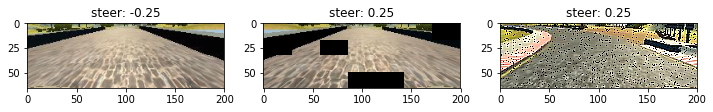

In [15]:
plt.figure(figsize=(12, 8))

images, steers = next(gen(range(len(data))))

plt.subplot(1, 3, 1)
plt.imshow(images[0])
plt.title('steer: ' + str(steers[0]))

plt.subplot(1, 3, 2)
plt.imshow(images[1])
plt.title('steer: ' + str(steers[1]))

plt.subplot(1, 3, 3)
plt.imshow(images[2])
plt.title('steer: ' + str(steers[2]))

## 训练

In [16]:
from keras.models import Model
from keras.layers import Input, Lambda, BatchNormalization, Flatten
from keras.layers import Dense, Conv2D

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
HEIGHT = 66
WEIGHT = 200

In [18]:
def MyModel():
    inputs = Input(shape=(HEIGHT, WEIGHT, 3))

    # 标准化
    x = Lambda(lambda x: x / 127.5 - 1.0,)(inputs)

    x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Dense(100, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(50, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(10, activation='relu')(x)

    outputs = Dense(1, name='predictions')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = MyModel()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
conv

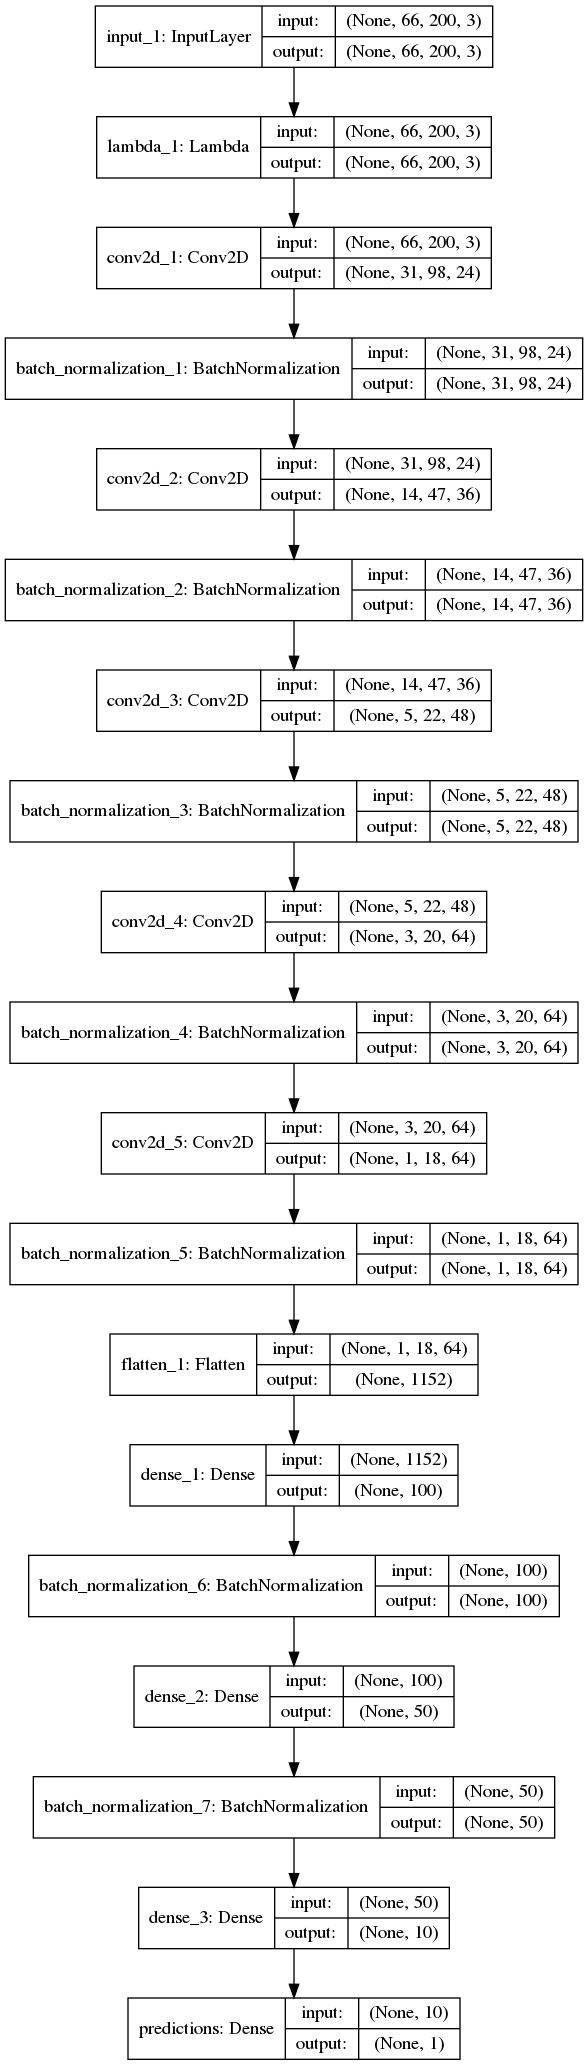

In [19]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file='model.png', show_shapes=True)
display.Image('model.png')

In [20]:
EPOCHS = 20
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2  # 20% 验证集

In [21]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(
    range(len(data)), test_size=VALIDATION_SPLIT, random_state=1)

In [22]:
len(train_data), len(valid_data)

(6428, 1608)

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

gen_train = gen(train_data, BATCH_SIZE, augment=True)  # 训练集
gen_valid = gen(valid_data, BATCH_SIZE, augment=False)  # 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(
    'model/model.h5', save_best_only=True, save_weights_only=False)
tensor_board = TensorBoard('log', write_graph=True, write_images=True)

model.compile(optimizer='adam', loss='mse')

In [24]:
model.fit_generator(gen_train,
                    steps_per_epoch=len(train_data) / BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=gen_valid,
                    validation_steps=len(valid_data) / BATCH_SIZE,
                    callbacks=[early_stopping, model_checkpoint, tensor_board])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
101/100 [==============================] - 19s 191ms/step - loss: 0.2515 - val_loss: 0.1039
Epoch 2/20
101/100 [==============================] - 17s 167ms/step - loss: 0.0611 - val_loss: 0.0579
Epoch 3/20
101/100 [==============================] - 17s 173ms/step - loss: 0.0475 - val_loss: 0.0636
Epoch 4/20
101/100 [==============================] - 17s 168ms/step - loss: 0.0388 - val_loss: 0.0560
Epoch 5/20
101/100 [==============================] - 17s 170ms/step - loss: 0.0320 - val_loss: 0.0460
Epoch 6/20
101/100 [==============================] - 17s 172ms/step - loss: 0.0290 - val_loss: 0.0569
Epoch 7/20
101/100 [==============================] - 17s 172ms/step - loss: 0.0263 - val_loss: 0.0486
Epoch 8/20
101/100 [==============================] - 17s 172ms/step - loss: 0.0233 - val_loss: 0.0455
Epoch 9/20
101/100 [==============================] - 17s 170ms/step - loss: 0.0233 - val_loss: 0.0440
Epoch 10/20
101/100 [====

## 测试

In [25]:
from keras.models import load_model

model = load_model('model/model.h5')

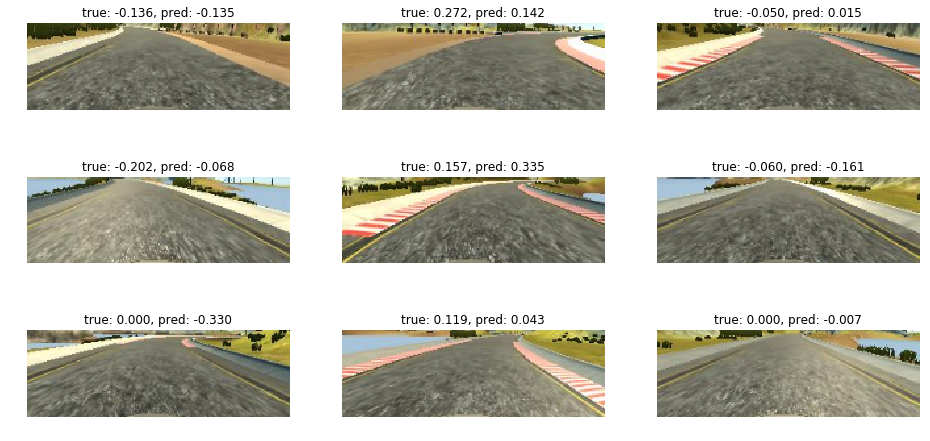

In [26]:
plt.figure(figsize=(16, 8))

for i in range(9):
    index = np.random.randint(0, len(data))
    image = process('../' + data['center'][index])
    steer = data['steering'][index]

    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = model.predict(x)

    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('true: %.3f, pred: %.3f' % (steer, pred))
    plt.axis('off')

## 可视化

https://raghakot.github.io/keras-vis/vis.visualization/#visualize_cam

`visualize_cam(model, layer_idx, filter_indices, seed_input, penultimate_layer_idx=None, backprop_modifier=None, grad_modifier=None)`
```
model: The keras.models.Model instance. The model input shape must be: (samples, channels, image_dims...) if  image_data_format=channels_first or (samples, image_dims..., channels) if image_data_format=channels_last.

layer_idx: The layer index within model.layers whose filters needs to be visualized.

filter_indices: filter indices within the layer to be maximized. If None, all filters are visualized. (Default value = None) For  keras.layers.Dense layer, filter_idx is interpreted as the output index. If you are visualizing final  keras.layers.Dense layer, consider switching 'softmax' activation for 'linear' using utils.apply_modifications for better results.

seed_input: The input image for which activation map needs to be visualized.

penultimate_layer_idx: The pre-layer to layer_idx whose feature maps should be used to compute gradients wrt filter output. If not provided, it is set to the nearest penultimate Conv or Pooling layer.

backprop_modifier: backprop modifier to use. See backprop_modifiers. If you don't specify anything, no backprop modification is applied. (Default value = None)

grad_modifier: gradient modifier to use. See grad_modifiers. If you don't specify anything, gradients are unchanged (Default value = None)
```

In [27]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
import matplotlib.cm as cm

In [28]:
layer_idx = utils.find_layer_idx(model, 'conv2d_5')
layer_idx

10

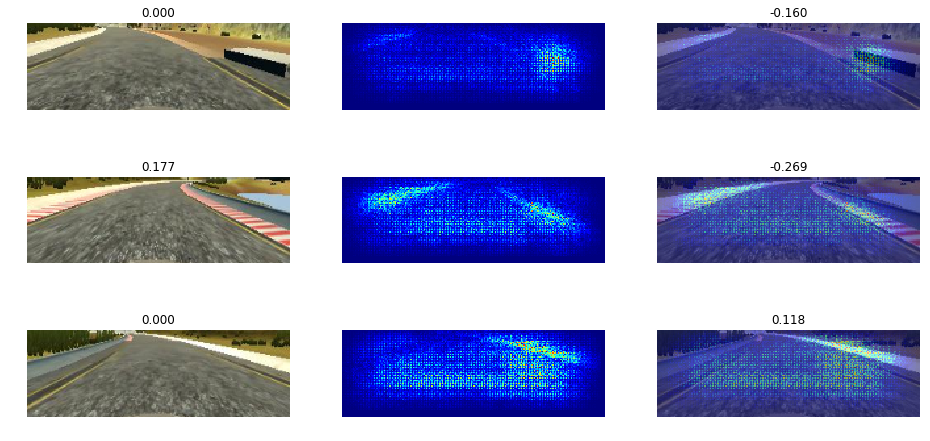

In [29]:
plt.figure(figsize=(16, 8))

for i in range(3):
    index = np.random.randint(0, len(data))
    image = process('../' + data['center'][index])
    steer = data['steering'][index]

    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = model.predict(x)[0][0]

    # 可视化
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=None,
                               seed_input=image, backprop_modifier='guided')
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    # 原始图
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title('%.3f' % steer)
    plt.axis('off')
    # 热力图
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(jet_heatmap)
    plt.axis('off')
    # 叠加图
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(overlay(jet_heatmap, image))
    plt.title('%.3f' % pred)
    plt.axis('off')

## 生成gif

In [30]:
origin = []
heatmaps = []
overlays = []

for image in data['center'][100:200]:
    image = process('../' + image)

    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = int(model.predict(x)[0][0])

    # 可视化
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=None,
                               seed_input=image, backprop_modifier='guided')
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    origin.append(image)
    heatmaps.append(jet_heatmap)
    overlays.append(overlay(jet_heatmap, image))

In [31]:
import imageio

# https://imageio.readthedocs.io/en/latest/userapi.html#imageio.mimread
imageio.mimsave('origin.gif', origin, duration=0.1)
imageio.mimsave('heatmap.gif', heatmaps, duration=0.1)
imageio.mimsave('overlay.gif', overlays, duration=0.1)